In [531]:
# Basic tools
import os
import sys
import re
from itertools import product

# Data tools
import numpy as np
import pandas as pd
from scipy.stats import norm

# Scraping tools
import requests
from bs4 import BeautifulSoup

# Viz tools
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import seaborn as sns

# NLP tools
import nltk
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.externals import joblib
from gensim.models import KeyedVectors

# Local
## Allow local relative imports
module_path = os.path.abspath('..')
include_path = os.path.join(module_path, 'include')
data_path = os.path.join(module_path, 'data')
models_path = os.path.join(module_path, 'models')
eda_path = os.path.join(module_path, 'eda')
if include_path not in sys.path:
    sys.path.append(include_path)
from my_nlp import Tokenizer

In [569]:
def mean_filtered(embed, doc, vocab_weights = None):
    embed_filtered = [x for x in doc.split() if x in embed.vocab]
    if len(embed_filtered) > 0:
        if vocab_weights is None:
            return embed[embed_filtered].mean(axis = 0)
        else:
            weight_filtered = [x for x in embed_filtered if x in vocab_weights]
            if len(weight_filtered) > 0:
                weights = np.array([vocab_weights[x] for x in weight_filtered])
                return weights.dot(embed[weight_filtered]) / weights.sum()
            else:
                return np.zeros(embed.vector_size, dtype = np.float32)
    else:
        return np.zeros(embed.vector_size, dtype = np.float32)

In [639]:
def logreg_distance(logreg, A, B):
    r = np.empty((A.shape[0], B.shape[0], A.shape[1] + B.shape[1]))
    for i in range(A.shape[0]):
        for j in range(B.shape[0]):
            r[i, j] = np.concatenate([A[i], B[j]], axis = 0)
    r = r.reshape(-1, A.shape[1] + B.shape[1])
    r = logreg.predict_proba(r)[:, 1].reshape(A.shape[0], B.shape[0])
    return r

In [24]:
def precision_recall(target_relevant_inds, target_selected_inds):
    n_selected = target_selected_inds.shape[1]
    n_relevant = len(target_relevant_inds)
    n_selected_relevant = intersect_vectorizer(target_relevant_inds, target_selected_inds)

    precision = n_selected_relevant / n_selected
    recall = n_selected_relevant / n_relevant
    return [precision, recall]

In [25]:
def populate_dataframe(vectorizer, origin_title, target_title,
                       origin_sents, target_sents,
                       origin_relevant_inds, target_relevant_inds,
                       n_selected = 10, scale = 10):
    sim_mat = cosine_similarity(*[vectorizer(x) for x in [origin_sents, target_sents]])
    sim_mat_T = sim_mat.T
    
    n_origin_relevent_inds = len(origin_relevant_inds)
    linked_titles = [np.array([x] * n_origin_relevent_inds) for x in [origin_title, target_title]]
    
    target_selected_inds_link = sim_mat[origin_relevant_inds].argsort(axis = 1)[:, :n_selected]
    target_selected_inds_wavg = weight_vectorizer(origin_sents, origin_relevant_inds, scale).dot(sim_mat).argsort(axis = 1)[:, :n_selected]
    target_selected_inds_summ = np.tile(np.arange(n_selected), (len(origin_relevant_inds), 1))
    target_selected_inds_rand = np.random.choice(np.arange(len(target_sents)), size = (n_origin_relevent_inds, n_selected))
    
    target_precision_recall = []
    for x in [target_selected_inds_link, target_selected_inds_wavg,
              target_selected_inds_summ, target_selected_inds_rand]:
        target_precision_recall.extend(precision_recall(target_relevant_inds, x))
    
    target_df = pd.DataFrame(linked_titles + target_precision_recall, index = ['origin_title', 'target_title',
                                                                               'link_precision', 'link_recall',
                                                                               'wavg_precision', 'wavg_recall',
                                                                               'summ_precision', 'summ_recall',
                                                                               'rand_precision', 'rand_recall']).T
    
    n_target_relevent_inds = len(target_relevant_inds)
    linked_titles = [np.array([x] * n_target_relevent_inds) for x in [target_title, origin_title]]
    
    origin_selected_inds_link = sim_mat_T[target_relevant_inds].argsort(axis = 1)[:, :n_selected]
    origin_selected_inds_wavg = weight_vectorizer(target_sents, target_relevant_inds, scale).dot(sim_mat_T).argsort(axis = 1)[:, :n_selected]
    origin_selected_inds_summ = np.tile(np.arange(n_selected), (len(target_relevant_inds), 1))
    origin_selected_inds_rand = np.random.choice(np.arange(len(origin_sents)), size = (len(target_relevant_inds), n_selected))    
    
    origin_precision_recall = []
    for x in [origin_selected_inds_link, origin_selected_inds_wavg,
              origin_selected_inds_summ, origin_selected_inds_rand]:
        origin_precision_recall.extend(precision_recall(origin_relevant_inds, x))
    
    origin_df = pd.DataFrame(linked_titles + origin_precision_recall, index = ['origin_title', 'target_title',
                                                                               'link_precision', 'link_recall',
                                                                               'wavg_precision', 'wavg_recall',
                                                                               'summ_precision', 'summ_recall',
                                                                               'rand_precision', 'rand_recall']).T
    
    return pd.concat([target_df, origin_df], axis = 0, ignore_index = True)

In [181]:
origin_title

'List_of_WWE_Hardcore_Champions'

In [180]:
wapi_url = "https://en.wikipedia.org/w/api.php"

origin_title, target_title = bilinks_df[['origin_title', 'target_title']].loc[0]
    
origin_wapi_params = {
    'action': "parse",
    'maxlag': 5,
    'page': origin_title,
    'prop': "text",
    'contentformat': "text/plain",
    'format': "json"
}

try:
    origin_data = sess.get(url = wapi_url, params = origin_wapi_params).json()
    origin_title_norm = origin_data['parse']['title']
    origin_text = origin_data['parse']['text']['*']
except KeyError:
    pass

origin_soup = BeautifulSoup(origin_text, 'html5lib')

origin_sents = []
origin_relevant_inds = []
sent_ind = 0
for p in origin_soup.find_all('p'):
    for p_split in p.decode_contents().split('\n'):
        for sent in nltk.sent_tokenize(p_split):
            sent_soup = BeautifulSoup(sent, 'html5lib').body
            sent_content = sent_soup.get_text().replace(u'\xa0', u' ')
            sent_content = re.sub('\[.*?\]', '', sent_content)
            sent_content = ' '.join(tok.load(sent_content).word_tokenize(lemmatize = True).word_tokens)
            if len(sent_content) > 0:
                for a in sent_soup.find_all('a'):
                    print(a.attrs['href'], target_title)
                    if (a.attrs['href'] == "/wiki/" + target_title) or (target_title_norm in sent):
                        origin_relevant_inds.append(sent_ind)
                        break
                origin_sents.append(sent_content)
                sent_ind += 1
origin_sents = np.array(origin_sents)

/wiki/WWE_Hardcore_Championship John_Layfield
/wiki/Professional_wrestling John_Layfield
/wiki/Professional_wrestling_championship John_Layfield
/wiki/WWE John_Layfield
/wiki/Professional_wrestling_promotion John_Layfield
/wiki/Professional_wrestling_match_types John_Layfield
/wiki/Hardcore_wrestling John_Layfield
/wiki/WWE_Raw John_Layfield
/wiki/Vince_McMahon John_Layfield
/wiki/Mick_Foley John_Layfield
/wiki/Referee_(professional_wrestling) John_Layfield
#cite_note-ruledead-1 John_Layfield
/wiki/WWE_Intercontinental_Championship John_Layfield
/wiki/Rob_Van_Dam John_Layfield
/wiki/Tommy_Dreamer John_Layfield
/wiki/Championship_unification John_Layfield
#cite_note-Dreamer'sbio-2 John_Layfield
/wiki/WWE_Brand_Extension John_Layfield
/wiki/Professional_wrestling_authority_figures John_Layfield
/wiki/Stone_Cold_Steve_Austin John_Layfield
#cite_note-FoleyawardbySCSA-3 John_Layfield
/wiki/Edge_(wrestler) John_Layfield
/wiki/Extreme_Championship_Wrestling John_Layfield
#cite_note-Foleyaward

In [494]:
def sentence_lists(origin_title, target_title, session = requests.Session(), tokenizer = Tokenizer()):
    wapi_url = "https://en.wikipedia.org/w/api.php"
    
    origin_wapi_params = {
        'action': "parse",
        'maxlag': 5,
        'page': origin_title,
        'prop': "text",
        'contentformat': "text/plain",
        'format': "json"
    }

    try:
        origin_data = session.get(url = wapi_url, params = origin_wapi_params).json()
        origin_title_norm = origin_data['parse']['title']
        origin_text = origin_data['parse']['text']['*']
    except KeyError:
        return None

    origin_soup = BeautifulSoup(origin_text, 'html5lib')

    target_wapi_params = {
        'action': "parse",
        'maxlag': 5,
        'page': target_title,
        'prop': "text",
        'format': "json"
    }

    try:
        target_data = session.get(url = wapi_url, params = target_wapi_params).json()
        target_title_norm = target_data['parse']['title']
        target_text = target_data['parse']['text']['*']
    except KeyError:
        return None
    
    target_soup = BeautifulSoup(target_text, 'html5lib')

    origin_sents = []
    origin_relevant_inds = []
    sent_ind = 0
    for p in origin_soup.find_all('p'):
        for p_split in p.decode_contents().split('\n'):
            for sent in nltk.sent_tokenize(p_split):
                sent_soup = BeautifulSoup(sent, 'html5lib').body
                sent_content = sent_soup.get_text().replace(u'\xa0', u' ')
                sent_content = re.sub('\[.*?\]', '', sent_content)
                sent_content = ' '.join(tokenizer.load(sent_content).word_tokenize(lemmatize = True).word_tokens)
                if len(sent_content) > 1:
                    for a in sent_soup.find_all('a'):
                        if (a.attrs['href'] == "/wiki/" + target_title) or (target_title_norm in sent):
                            origin_relevant_inds.append(sent_ind)
                            break
                    origin_sents.append(sent_content)
                    sent_ind += 1
    origin_sents = np.array(origin_sents)

    target_sents = []
    target_relevant_inds = []
    sent_ind = 0
    for p in target_soup.find_all('p'):
        for p_split in p.decode_contents().split('\n'):
            for sent in nltk.sent_tokenize(p_split):
                sent_soup = BeautifulSoup(sent, 'html5lib').body
                sent_content = sent_soup.get_text().replace(u'\xa0', u' ')
                sent_content = re.sub('\[.*?\]', '', sent_content)
                sent_content = ' '.join(tokenizer.load(sent_content).word_tokenize(lemmatize = True).word_tokens)
                if len(sent_content) > 1:
                    for a in sent_soup.find_all('a'):
                        if (a.attrs['href'] == "/wiki/" + origin_title) or (origin_title_norm in sent):
                            target_relevant_inds.append(sent_ind)
                            break
                    target_sents.append(sent_content)
                    sent_ind += 1
    target_sents = np.array(target_sents)
    
    return [origin_sents, target_sents], [origin_relevant_inds, target_relevant_inds]

In [570]:
tok = Tokenizer()
sess = requests.Session()

wiki2vec_embed = KeyedVectors.load(models_path + '/wiki2vec/en.model.kv')
wiki2vec_vectorizer = np.vectorize(lambda x: mean_filtered(wiki2vec_embed, x), signature = '()->(n)')
wiki2vec_tfidf_embed = joblib.load(models_path + '/tfidf/enwiki-latest-all-wiki2vec_tfidf_embed.joblib')
wiki2vec_idf = dict(zip(wiki2vec_tfidf_embed.get_feature_names(), wiki2vec_tfidf_embed.idf_))
tfidf_wiki2vec_vectorizer = np.vectorize(lambda x: mean_filtered(wiki2vec_embed, x, vocab_weights = wiki2vec_idf), signature = '()->(n)')

glove_embed = KeyedVectors.load_word2vec_format(models_path + '/glove/word2vec.glove.6B.300d.txt')
glove_vectorizer = np.vectorize(lambda x: mean_filtered(glove_embed, x), signature = '()->(n)')
glove_tfidf_embed = joblib.load(models_path + '/tfidf/enwiki-latest-all-glove_tfidf_embed.joblib')
glove_idf = dict(zip(glove_tfidf_embed.get_feature_names(), glove_tfidf_embed.idf_))
tfidf_glove_vectorizer = np.vectorize(lambda x: mean_filtered(glove_embed, x, vocab_weights = glove_idf), signature = '()->(n)')

weight_vectorizer = np.vectorize(lambda x, y, z: norm.pdf(range(x.size), loc = y, scale = z), signature = '(m),(),()->(n)')
intersect_vectorizer = np.vectorize(lambda x, y: np.intersect1d(x, y).size, signature = '(m),(n)->()')

In [70]:
# max_df = 0.8
# min_df = 5

# wiki2vec_tfidf_vectorizer = TfidfVectorizer(min_df = min_df, max_df = max_df,
#                                    stop_words = 'english',
#                                    vocabulary = iter(wiki2vec_embed.vocab.keys())).fit(samples_df.sentence)

# joblib.dump(wiki2vec_tfidf_vectorizer, models_path + '/tfidf/enwiki-latest-all-wiki2vec_tfidf_vectorizer.joblib')
# wiki2vec_tfidf_vectorizer = joblib.load(models_path + '/tfidf/enwiki-latest-all-wiki2vec_tfidf_vectorizer.joblib')

In [424]:
bilinks_df = pd.read_csv(data_path + '/clickstream-enwiki-2018-08-bilinks_sample.tsv', sep = '\t')

In [574]:
samples_df = pd.read_csv(data_path + '/enwiki-latest-all-titles-sentence_samples.tsv', sep = '\t')

In [495]:
def get_df(sentences, indices, rand_indices, v_cols, vect, dist):
    origin_sents, target_sents = sentences
    origin_inds, target_inds = indices
    target_rand_inds, origin_rand_inds = rand_indices
    dist_mat = dist(*[vect(x) for x in sentences])
    
    df = pd.DataFrame([], columns = v_cols)

    for i, rand_j in zip(origin_inds, target_rand_inds):
        j = dist_mat[i].argmin()
        linked = dist_mat[i, j]
        baseline = dist_mat[i, 0]
#         random = np.random.choice(dist_mat[i])
        random = dist_mat[i, rand_j]
        dist_row = dist_mat[i]
        mean = dist_row.mean()
        n_selected = dist_row[dist_row < mean].size
        temp_df = pd.DataFrame(dict(zip(v_cols, [target_sents[j], linked, baseline, random, n_selected])), index = [0])
        df = df.append(temp_df, ignore_index = True)

    for rand_i, j in zip(origin_rand_inds, target_inds):
        i = dist_mat[:, j].argmin()
        linked = dist_mat[i, j]
        baseline = dist_mat[0, j]
#         random = np.random.choice(dist_mat[:, j])
        random = dist_mat[rand_i, j]
        dist_col = dist_mat[:, j]
        mean = dist_col.mean()
        n_selected = dist_col[dist_col < mean].size
        temp_df = pd.DataFrame(dict(zip(v_cols, [origin_sents[i], linked, baseline, random, n_selected])), index = [0])
        df = df.append(temp_df, ignore_index = True)
    
    return df

In [503]:
origin_title, target_title = bilinks_df[['origin_title', 'target_title']].loc[8]

sentences, indices = sentence_lists(origin_title, target_title, session = sess, tokenizer = tok)
origin_sents, target_sents = sentences
origin_inds, target_inds = indices
rand_indices = [np.random.choice(range(sentences[-1 - i].size), size = len(indices[i])) for i in range(len(indices))]

v_cols = ['origin_title', 'target_title', 'origin_sent', 'n_relevant']
v_df = pd.DataFrame([], columns = v_cols)

for i in origin_inds:
    temp_df = pd.DataFrame(dict(zip(v_cols, [origin_title, target_title, origin_sents[i], len(target_inds)])), index = [0])
    v_df = v_df.append(temp_df, ignore_index = True)

for j in target_inds:
    temp_df = pd.DataFrame(dict(zip(v_cols, [target_title, origin_title, target_sents[j], len(origin_inds)])), index = [0])
    v_df = v_df.append(temp_df, ignore_index = True)

In [418]:
v_df = pd.concat([v_df, get_df(sentences, indices, rand_indices, ['target_sent_tfidf_glove_cos', 'linked_tfidf_glove_cos', 'baseline_tfidf_glove_cos', 'random_tfidf_glove_cos', 'n_selected_tfidf_glove_cos'], tfidf_glove_vectorizer, lambda x, y: 1 - cosine_similarity(x, y))], axis = 1)
v_df = pd.concat([v_df, get_df(sentences, indices, rand_indices, ['target_sent_tfidf_glove_euc', 'linked_tfidf_glove_euc', 'baseline_tfidf_glove_euc', 'random_tfidf_glove_euc', 'n_selected_tfidf_glove_euc'], tfidf_glove_vectorizer, euclidean_distances)], axis = 1)

In [218]:
# Linked o->t
[max([sim_mat[i, j] for j in target_inds]) for i in origin_inds]

[0.8986875355989357, 0.900511137331619]

In [219]:
# Linked t->o
[max([sim_mat[i, j] for i in origin_inds]) for j in target_inds]

[0.900511137331619, 0.8986273019238108]

In [220]:
# Baseline o->t
[sim_mat[i, 0] for i in origin_inds]

[0.8986875355989357, 0.900511137331619]

In [221]:
# Baseline t->o
[sim_mat[0, j] for j in target_inds]

[0.7029435307802774, 0.7117245954392029]

In [243]:
# Random o->t
[np.random.choice(sim_mat[i]) for i in origin_inds]

[0.8645868726959947, 0.7975127787191929]

In [244]:
# Random t->o
[np.random.choice(sim_mat[:, j]) for j in target_inds]

[0.8441983353592979, 0.8739112557510054]

In [532]:
valid_bkp_df = pd.read_csv(data_path + '/clickstream-enwiki-2018-08-validation_bkp2.tsv', sep = '\t')

In [584]:
n_rows = 4
n_cols = 2

row_labels = ["wiki2vec", "tfidf_wiki2vec", "glove", "tfidf_glove"]
col_labels = ["cos", "euc"]

row_vectorizers = [wiki2vec_vectorizer, tfidf_wiki2vec_vectorizer, glove_vectorizer, tfidf_glove_vectorizer]

for i in range(n_rows):
    for j in range(n_cols):
        key = lambda x: "target_sent_{}_{}_{}".format(x, row_labels[i], col_labels[j])     
        
        X1 = np.concatenate([row_vectorizers[i](valid_bkp_df.origin_sent), row_vectorizers[i](valid_bkp_df[key('linked')])], axis = 1)
        X2 = np.concatenate([row_vectorizers[i](valid_bkp_df.origin_sent), row_vectorizers[i](valid_bkp_df[key('random')])], axis = 1)
        X = np.concatenate([X1, X2], axis = 0)
        y = np.concatenate([np.zeros(X1.shape[0]), np.ones(X2.shape[0])], axis = 0)

        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

        logreg = LogisticRegression(solver = 'liblinear',
                                    multi_class = 'ovr').fit(X_train, y_train)
        
        pd.DataFrame({'y_predict': logreg.predict(X_test), 'y_actual': y_test}).to_csv(models_path + '/logreg/logreg_{}_{}.test'.format(row_labels[i], col_labels[j]), sep = '\t', index = False)
        joblib.dump(logreg, models_path + '/logreg/logreg_{}_{}.joblib'.format(row_labels[i], col_labels[j])) 

In [612]:
def logreg_dist(A, B):
    r = np.empty((A.shape[0], B.shape[0]))
    for i in range(A.shape[0]):
        for j in range(B.shape[0]):
            r[i, j] = logreg.predict_proba(np.concatenate([A[i], B[j]], axis = 0).reshape(1, -1))[0, 1]
    return r

In [691]:
valid_df = pd.read_csv(data_path + '/clickstream-enwiki-2018-08-validation.tsv', sep = '\t')

/usr/local/anaconda3/envs/insight/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


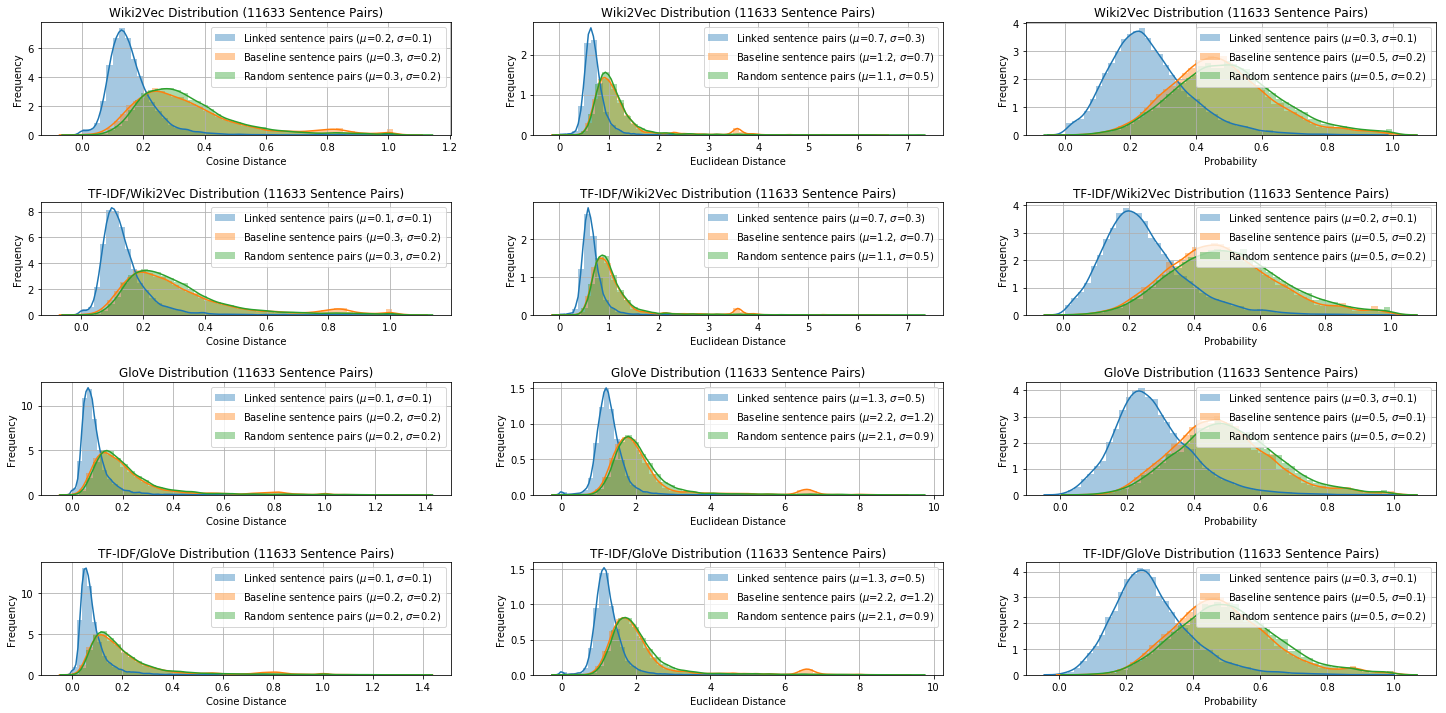

In [692]:
n_rows = 4
n_cols = 3

row_labels = ["wiki2vec", "tfidf_wiki2vec", "glove", "tfidf_glove"]
col_labels = ["cos", "euc", "logreg_cos"]

row_titles = ["Wiki2Vec", "TF-IDF/Wiki2Vec", "GloVe", "TF-IDF/GloVe"]
col_axes = ["Cosine Distance", "Euclidean Distance", "Probability"]

fig, ax = plt.subplots(nrows = n_rows, ncols = n_cols)
fig.set_size_inches(25, 12)
plt.subplots_adjust(hspace = 0.6)
for i in range(n_rows):
    for j in range(n_cols):
        key = lambda x: "dist_{}_{}_{}".format(x, row_labels[i], col_labels[j])
        mu = valid_df[key("linked")].mean()
        sigma = valid_df[key("linked")].std()
        sns.distplot(valid_df[key("linked")], ax = ax[i][j], label = "Linked sentence pairs ($\mu$={:.1f}, $\sigma$={:.1f})".format(mu, sigma))
        mu = valid_df[key("baseline")].mean()
        sigma = valid_df[key("baseline")].std()
        sns.distplot(valid_df[key("baseline")], ax = ax[i][j], label = "Baseline sentence pairs ($\mu$={:.1f}, $\sigma$={:.1f})".format(mu, sigma))
        mu = valid_df[key("random")].mean()
        sigma = valid_df[key("random")].std()
        sns.distplot(valid_df[key("random")], ax = ax[i][j], label = "Random sentence pairs ($\mu$={:.1f}, $\sigma$={:.1f})".format(mu, sigma))
        ax[i][j].legend()
        ax[i][j].grid()
        ax[i][j].set_title("{} Distribution ({} Sentence Pairs)".format(row_titles[i], valid_df.shape[0]))
        ax[i][j].set_xlabel("{}".format(col_axes[j]))
        ax[i][j].set_ylabel("Frequency")
fig.savefig(eda_path + '/models_distrib.png')

In [679]:
a = "<b>Steven K. Conine</b> (born 1972/73) is an American <a href=\"/wiki/Billionaire\" title=\"Billionaire\">billionaire</a> businessman, and the chief technology officer, chairman and co-founder (with <a href=\"/wiki/Niraj_Shah\" title=\"Niraj Shah\">Niraj Shah</a>) of online retailer <a href=\"/wiki/Wayfair\" title=\"Wayfair\">Wayfair</a>.\nConine graduated from <a href=\"/wiki/Cornell_University\" title=\"Cornell University\">Cornell University</a>, where he earned a bachelor's degree in engineering in 1995.<sup id=\"cite_ref-Bloomberg_Profile_1-1\" class=\"reference\"><a href=\"#cite_note-Bloomberg_Profile-1\">[1]</a></sup><sup id=\"cite_ref-wayfairfounders_2-0\" class=\"reference\"><a href=\"#cite_note-wayfairfounders-2\">[2]</a></sup> Conine co-founded Wayfair in 2002, and Is currently the co-chairman of the board.<sup id=\"cite_ref-3\" class=\"reference\"><a href=\"#cite_note-3\">[3]</a></sup> In June 2017, with Wayfair's rising share price Conine and his co-founder <a href=\"/wiki/Niraj_Shah\" title=\"Niraj Shah\">Niraj Shah</a> both became billionaires, each with a net worth of $1.37 billion.<sup id=\"cite_ref-4\" class=\"reference\"><a href=\"#cite_note-4\">[4]</a></sup><sup id=\"cite_ref-5\" class=\"reference\"><a href=\"#cite_note-5\">[5]</a></sup> Conine is married to Alexi, they have three children, and live in Boston.<sup id=\"cite_ref-6\" class=\"reference\"><a href=\"#cite_note-6\">[6]</a></sup><sup id=\"cite_ref-mountainliving.com_7-0\" class=\"reference\"><a href=\"#cite_note-mountainliving.com-7\">[7]</a></sup> They have a holiday home in <a href=\"/wiki/Jackson_Hole\" title=\"Jackson Hole\">Jackson Hole</a>, Wyoming.<sup id=\"cite_ref-mountainliving.com_7-1\" class=\"reference\"><a href=\"#cite_note-mountainliving.com-7\">[7]</a></sup><sup id=\"cite_ref-8\" class=\"reference\"><a href=\"#cite_note-8\">[8]</a></sup>"

In [681]:
a

'<b>Steven K. Conine</b> (born 1972/73) is an American <a href="/wiki/Billionaire" title="Billionaire">billionaire</a> businessman, and the chief technology officer, chairman and co-founder (with <a href="/wiki/Niraj_Shah" title="Niraj Shah">Niraj Shah</a>) of online retailer <a href="/wiki/Wayfair" title="Wayfair">Wayfair</a>.\nConine graduated from <a href="/wiki/Cornell_University" title="Cornell University">Cornell University</a>, where he earned a bachelor\'s degree in engineering in 1995.<sup id="cite_ref-Bloomberg_Profile_1-1" class="reference"><a href="#cite_note-Bloomberg_Profile-1">[1]</a></sup><sup id="cite_ref-wayfairfounders_2-0" class="reference"><a href="#cite_note-wayfairfounders-2">[2]</a></sup> Conine co-founded Wayfair in 2002, and Is currently the co-chairman of the board.<sup id="cite_ref-3" class="reference"><a href="#cite_note-3">[3]</a></sup> In June 2017, with Wayfair\'s rising share price Conine and his co-founder <a href="/wiki/Niraj_Shah" title="Niraj Shah">

In [684]:
b = re.sub(r'\.(<sup.*?/sup>)', r'\1.', a)
while b != a:
    a = b
    b = re.sub(r'\.(<sup.*?/sup>)', r'\1.', a)

In [685]:
b

'<b>Steven K. Conine</b> (born 1972/73) is an American <a href="/wiki/Billionaire" title="Billionaire">billionaire</a> businessman, and the chief technology officer, chairman and co-founder (with <a href="/wiki/Niraj_Shah" title="Niraj Shah">Niraj Shah</a>) of online retailer <a href="/wiki/Wayfair" title="Wayfair">Wayfair</a>.\nConine graduated from <a href="/wiki/Cornell_University" title="Cornell University">Cornell University</a>, where he earned a bachelor\'s degree in engineering in 1995<sup id="cite_ref-Bloomberg_Profile_1-1" class="reference"><a href="#cite_note-Bloomberg_Profile-1">[1]</a></sup><sup id="cite_ref-wayfairfounders_2-0" class="reference"><a href="#cite_note-wayfairfounders-2">[2]</a></sup>. Conine co-founded Wayfair in 2002, and Is currently the co-chairman of the board<sup id="cite_ref-3" class="reference"><a href="#cite_note-3">[3]</a></sup>. In June 2017, with Wayfair\'s rising share price Conine and his co-founder <a href="/wiki/Niraj_Shah" title="Niraj Shah">

In [676]:
b = BeautifulSoup(a, 'html5lib')

In [677]:
for x in b.find_all("sup", {'class': 'reference'}):
    x.decompose()

In [678]:
b

<html><head></head><body><b>Steven K. Conine</b> (born 1972/73) is an American <a href="/wiki/Billionaire" title="Billionaire">billionaire</a> businessman, and the chief technology officer, chairman and co-founder (with <a href="/wiki/Niraj_Shah" title="Niraj Shah">Niraj Shah</a>) of online retailer <a href="/wiki/Wayfair" title="Wayfair">Wayfair</a>.
Conine graduated from <a href="/wiki/Cornell_University" title="Cornell University">Cornell University</a>, where he earned a bachelor's degree in engineering in 1995. Conine co-founded Wayfair in 2002, and Is currently the co-chairman of the board. In June 2017, with Wayfair's rising share price Conine and his co-founder <a href="/wiki/Niraj_Shah" title="Niraj Shah">Niraj Shah</a> both became billionaires, each with a net worth of $1.37 billion. Conine is married to Alexi, they have three children, and live in Boston. They have a holiday home in <a href="/wiki/Jackson_Hole" title="Jackson Hole">Jackson Hole</a>, Wyoming.</body></html>

/usr/local/anaconda3/envs/insight/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


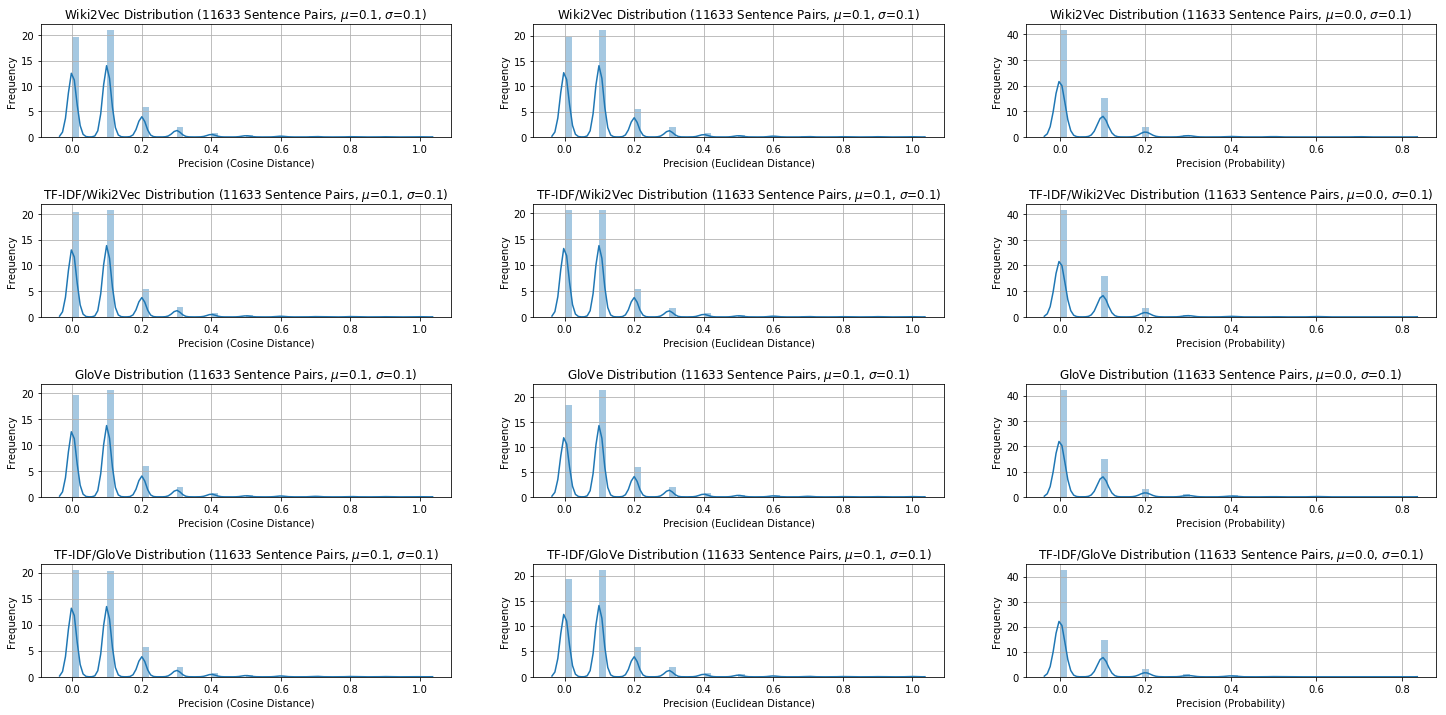

In [693]:
n_rows = 4
n_cols = 3

row_labels = ["wiki2vec", "tfidf_wiki2vec", "glove", "tfidf_glove"]
col_labels = ["cos", "euc", "logreg_cos"]

row_titles = ["Wiki2Vec", "TF-IDF/Wiki2Vec", "GloVe", "TF-IDF/GloVe"]
col_axes = ["Cosine Distance", "Euclidean Distance", "Probability"]

fig, ax = plt.subplots(nrows = n_rows, ncols = n_cols)
fig.set_size_inches(25, 12)
plt.subplots_adjust(hspace = 0.6)
for i in range(n_rows):
    for j in range(n_cols):
        n_relevant_selected = valid_df["n_relevant_selected_{}_{}".format(row_labels[i], col_labels[j])]
        n_selected = valid_df["n_selected"]
        precision = (n_relevant_selected / n_selected).dropna()
        mu = precision.mean()
        sigma = precision.std()
        sns.distplot(precision, ax = ax[i][j])
        ax[i][j].grid()
        ax[i][j].set_title("{} Distribution ({} Sentence Pairs, $\mu$={:.1f}, $\sigma$={:.1f})".format(row_titles[i], valid_df.shape[0], mu, sigma))
        ax[i][j].set_xlabel("Precision ({})".format(col_axes[j]))
        ax[i][j].set_ylabel("Frequency")
fig.savefig(eda_path + '/models_precision.png')

/usr/local/anaconda3/envs/insight/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


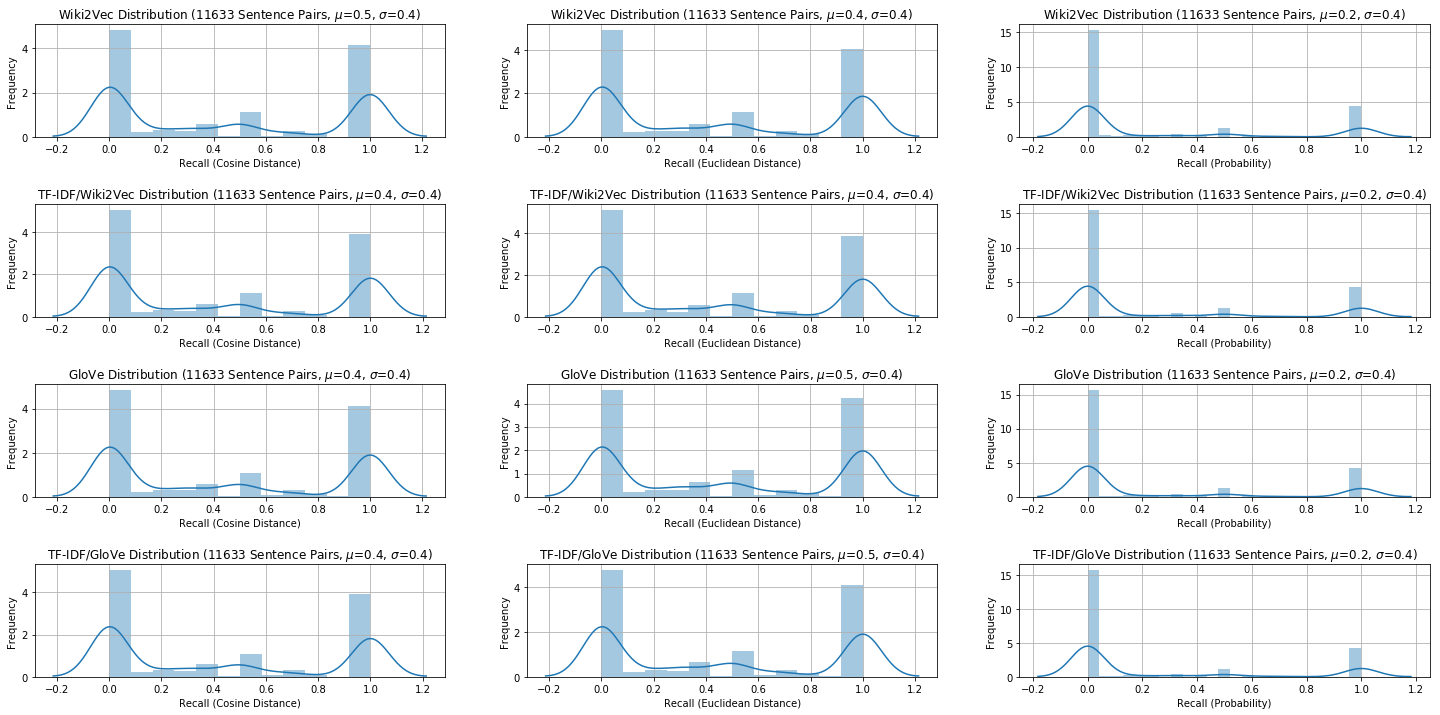

In [694]:
n_rows = 4
n_cols = 3

row_labels = ["wiki2vec", "tfidf_wiki2vec", "glove", "tfidf_glove"]
col_labels = ["cos", "euc", "logreg_cos"]

row_titles = ["Wiki2Vec", "TF-IDF/Wiki2Vec", "GloVe", "TF-IDF/GloVe"]
col_axes = ["Cosine Distance", "Euclidean Distance", "Probability"]

fig, ax = plt.subplots(nrows = n_rows, ncols = n_cols)
fig.set_size_inches(25, 12)
plt.subplots_adjust(hspace = 0.6)
for i in range(n_rows):
    for j in range(n_cols):
        n_relevant_selected = valid_df["n_relevant_selected_{}_{}".format(row_labels[i], col_labels[j])]
        n_relevant = valid_df["n_relevant"]
        recall = (n_relevant_selected / n_relevant).dropna()
        mu = recall.mean()
        sigma = recall.std()
        sns.distplot(recall, ax = ax[i][j])
        ax[i][j].grid()
        ax[i][j].set_title("{} Distribution ({} Sentence Pairs, $\mu$={:.1f}, $\sigma$={:.1f})".format(row_titles[i], valid_df.shape[0], mu, sigma))
        ax[i][j].set_xlabel("Recall ({})".format(col_axes[j]))
        ax[i][j].set_ylabel("Frequency")
fig.savefig(eda_path + '/models_recall.png')

/usr/local/anaconda3/envs/insight/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


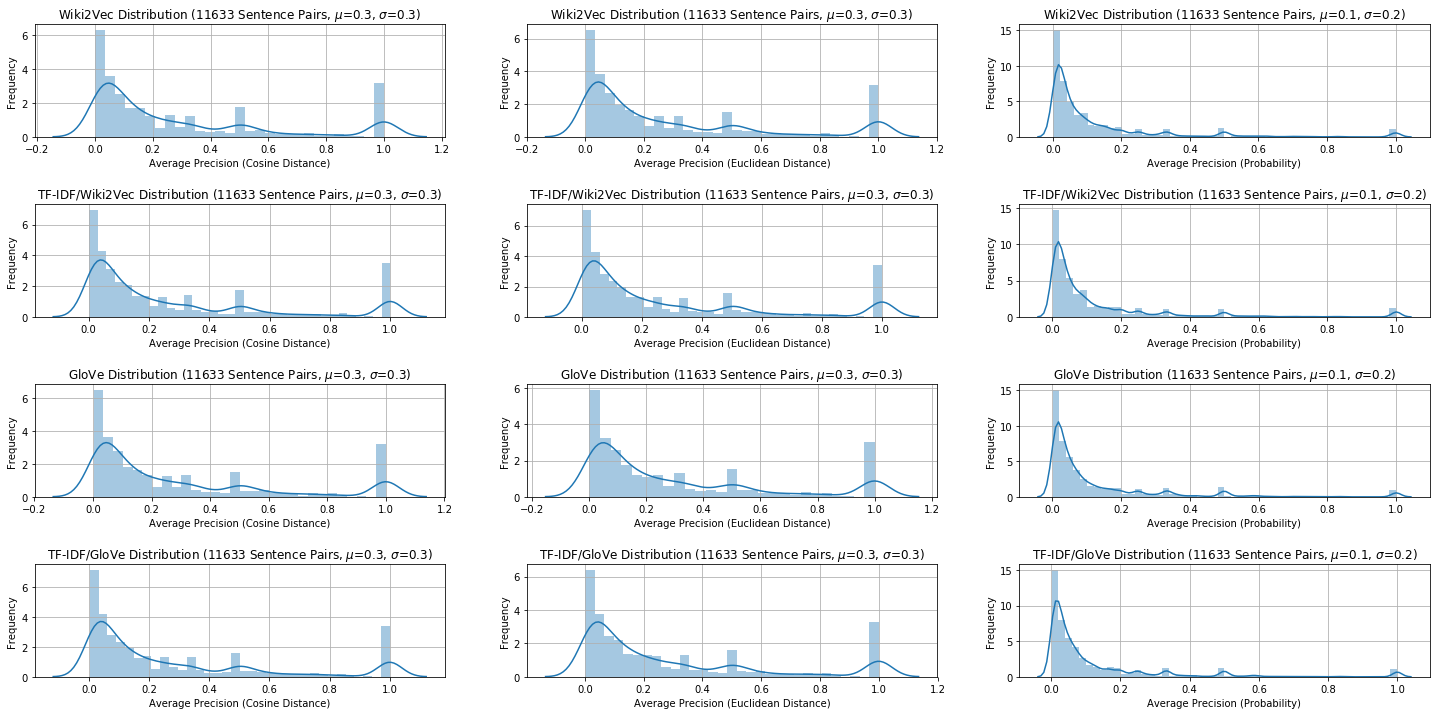

In [695]:
n_rows = 4
n_cols = 3

row_labels = ["wiki2vec", "tfidf_wiki2vec", "glove", "tfidf_glove"]
col_labels = ["cos", "euc", "logreg_cos"]

row_titles = ["Wiki2Vec", "TF-IDF/Wiki2Vec", "GloVe", "TF-IDF/GloVe"]
col_axes = ["Cosine Distance", "Euclidean Distance", "Probability"]

fig, ax = plt.subplots(nrows = n_rows, ncols = n_cols)
fig.set_size_inches(25, 12)
plt.subplots_adjust(hspace = 0.6)
for i in range(n_rows):
    for j in range(n_cols):
        avg_prec = valid_df["avg_prec_{}_{}".format(row_labels[i], col_labels[j])].dropna()
        mu = avg_prec.mean()
        sigma = avg_prec.std()
        sns.distplot(avg_prec, ax = ax[i][j])
        ax[i][j].grid()
        ax[i][j].set_title("{} Distribution ({} Sentence Pairs, $\mu$={:.1f}, $\sigma$={:.1f})".format(row_titles[i], valid_df.shape[0], mu, sigma))
        ax[i][j].set_xlabel("Average Precision ({})".format(col_axes[j]))
        ax[i][j].set_ylabel("Frequency")
fig.savefig(eda_path + '/models_avg_prec.png')

/usr/local/anaconda3/envs/insight/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


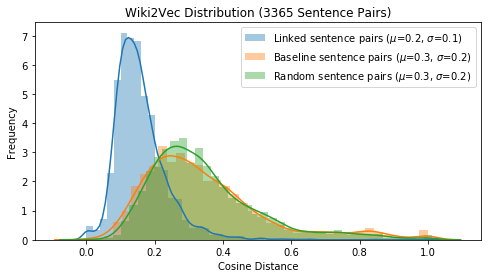

In [447]:
fig = plt.figure(figsize = (8, 4))
mu = valid_df.dist_linked_wiki2vec_cos.mean()
sigma = valid_df.dist_linked_wiki2vec_cos.std()
sns.distplot(valid_df.dist_linked_wiki2vec_cos, label = "Linked sentence pairs ($\mu$={:.1f}, $\sigma$={:.1f})".format(mu, sigma))
mu = valid_df.dist_baseline_wiki2vec_cos.mean()
sigma = valid_df.dist_baseline_wiki2vec_cos.std()
sns.distplot(valid_df.dist_baseline_wiki2vec_cos, label = "Baseline sentence pairs ($\mu$={:.1f}, $\sigma$={:.1f})".format(mu, sigma))
mu = valid_df.dist_random_wiki2vec_cos.mean()
sigma = valid_df.dist_random_wiki2vec_cos.std()
sns.distplot(valid_df.dist_random_wiki2vec_cos, label = "Random sentence pairs ($\mu$={:.1f}, $\sigma$={:.1f})".format(mu, sigma))
plt.legend()
plt.title("Wiki2Vec Distribution ({} Sentence Pairs)".format(valid_df.shape[0]))
plt.xlabel("Cosine Distance")
plt.ylabel("Frequency")
fig.savefig(eda_path + '/wiki2vec_cos.png')

/usr/local/anaconda3/envs/insight/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


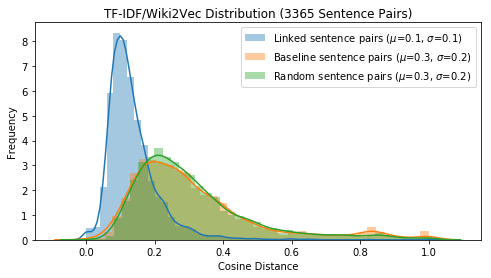

In [448]:
fig = plt.figure(figsize = (8, 4))
mu = valid_df.dist_linked_tfidf_wiki2vec_cos.mean()
sigma = valid_df.dist_linked_tfidf_wiki2vec_cos.std()
sns.distplot(valid_df.dist_linked_tfidf_wiki2vec_cos, label = "Linked sentence pairs ($\mu$={:.1f}, $\sigma$={:.1f})".format(mu, sigma))
mu = valid_df.dist_baseline_tfidf_wiki2vec_cos.mean()
sigma = valid_df.dist_baseline_tfidf_wiki2vec_cos.std()
sns.distplot(valid_df.dist_baseline_tfidf_wiki2vec_cos, label = "Baseline sentence pairs ($\mu$={:.1f}, $\sigma$={:.1f})".format(mu, sigma))
mu = valid_df.dist_random_tfidf_wiki2vec_cos.mean()
sigma = valid_df.dist_random_tfidf_wiki2vec_cos.std()
sns.distplot(valid_df.dist_random_tfidf_wiki2vec_cos, label = "Random sentence pairs ($\mu$={:.1f}, $\sigma$={:.1f})".format(mu, sigma))
plt.legend()
plt.title("TF-IDF/Wiki2Vec Distribution ({} Sentence Pairs)".format(valid_df.shape[0]))
plt.xlabel("Cosine Distance")
plt.ylabel("Frequency")
fig.savefig(eda_path + '/tfidf_wiki2vec_cos.png')

/usr/local/anaconda3/envs/insight/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


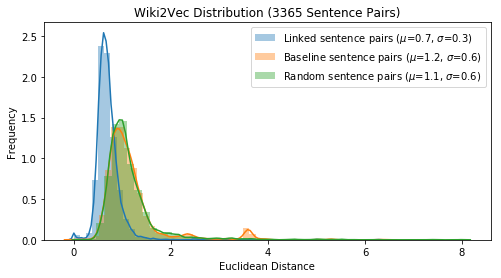

In [449]:
fig = plt.figure(figsize = (8, 4))
mu = valid_df.dist_linked_wiki2vec_euc.mean()
sigma = valid_df.dist_linked_wiki2vec_euc.std()
sns.distplot(valid_df.dist_linked_wiki2vec_euc, label = "Linked sentence pairs ($\mu$={:.1f}, $\sigma$={:.1f})".format(mu, sigma))
mu = valid_df.dist_baseline_wiki2vec_euc.mean()
sigma = valid_df.dist_baseline_wiki2vec_euc.std()
sns.distplot(valid_df.dist_baseline_wiki2vec_euc, label = "Baseline sentence pairs ($\mu$={:.1f}, $\sigma$={:.1f})".format(mu, sigma))
mu = valid_df.dist_random_wiki2vec_euc.mean()
sigma = valid_df.dist_random_wiki2vec_euc.std()
sns.distplot(valid_df.dist_random_wiki2vec_euc, label = "Random sentence pairs ($\mu$={:.1f}, $\sigma$={:.1f})".format(mu, sigma))
plt.legend()
plt.title("Wiki2Vec Distribution ({} Sentence Pairs)".format(valid_df.shape[0]))
plt.xlabel("Euclidean Distance")
plt.ylabel("Frequency")
fig.savefig(eda_path + '/wiki2vec_euc.png')

/usr/local/anaconda3/envs/insight/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


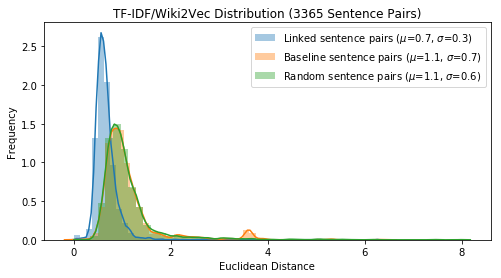

In [450]:
fig = plt.figure(figsize = (8, 4))
mu = valid_df.dist_linked_tfidf_wiki2vec_euc.mean()
sigma = valid_df.dist_linked_tfidf_wiki2vec_euc.std()
sns.distplot(valid_df.dist_linked_tfidf_wiki2vec_euc, label = "Linked sentence pairs ($\mu$={:.1f}, $\sigma$={:.1f})".format(mu, sigma))
mu = valid_df.dist_baseline_tfidf_wiki2vec_euc.mean()
sigma = valid_df.dist_baseline_tfidf_wiki2vec_euc.std()
sns.distplot(valid_df.dist_baseline_tfidf_wiki2vec_euc, label = "Baseline sentence pairs ($\mu$={:.1f}, $\sigma$={:.1f})".format(mu, sigma))
mu = valid_df.dist_random_tfidf_wiki2vec_euc.mean()
sigma = valid_df.dist_random_tfidf_wiki2vec_euc.std()
sns.distplot(valid_df.dist_random_tfidf_wiki2vec_euc, label = "Random sentence pairs ($\mu$={:.1f}, $\sigma$={:.1f})".format(mu, sigma))
plt.legend()
plt.title("TF-IDF/Wiki2Vec Distribution ({} Sentence Pairs)".format(valid_df.shape[0]))
plt.xlabel("Euclidean Distance")
plt.ylabel("Frequency")
fig.savefig(eda_path + '/tfidf_wiki2vec_euc.png')

/usr/local/anaconda3/envs/insight/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


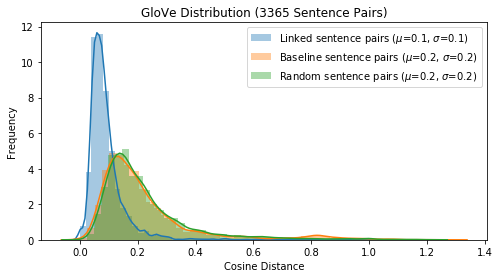

In [451]:
fig = plt.figure(figsize = (8, 4))
mu = valid_df.dist_linked_glove_cos.mean()
sigma = valid_df.dist_linked_glove_cos.std()
sns.distplot(valid_df.dist_linked_glove_cos, label = "Linked sentence pairs ($\mu$={:.1f}, $\sigma$={:.1f})".format(mu, sigma))
mu = valid_df.dist_baseline_glove_cos.mean()
sigma = valid_df.dist_baseline_glove_cos.std()
sns.distplot(valid_df.dist_baseline_glove_cos, label = "Baseline sentence pairs ($\mu$={:.1f}, $\sigma$={:.1f})".format(mu, sigma))
mu = valid_df.dist_random_glove_cos.mean()
sigma = valid_df.dist_random_glove_cos.std()
sns.distplot(valid_df.dist_random_glove_cos, label = "Random sentence pairs ($\mu$={:.1f}, $\sigma$={:.1f})".format(mu, sigma))
plt.legend()
plt.title("GloVe Distribution ({} Sentence Pairs)".format(valid_df.shape[0]))
plt.xlabel("Cosine Distance")
plt.ylabel("Frequency")
fig.savefig(eda_path + '/glove_cos.png')

/usr/local/anaconda3/envs/insight/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


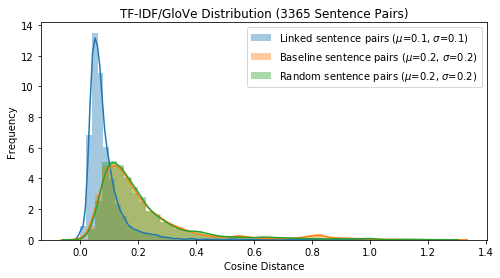

In [452]:
fig = plt.figure(figsize = (8, 4))
mu = valid_df.dist_linked_tfidf_glove_cos.mean()
sigma = valid_df.dist_linked_tfidf_glove_cos.std()
sns.distplot(valid_df.dist_linked_tfidf_glove_cos, label = "Linked sentence pairs ($\mu$={:.1f}, $\sigma$={:.1f})".format(mu, sigma))
mu = valid_df.dist_baseline_tfidf_glove_cos.mean()
sigma = valid_df.dist_baseline_tfidf_glove_cos.std()
sns.distplot(valid_df.dist_baseline_tfidf_glove_cos, label = "Baseline sentence pairs ($\mu$={:.1f}, $\sigma$={:.1f})".format(mu, sigma))
mu = valid_df.dist_random_tfidf_glove_cos.mean()
sigma = valid_df.dist_random_tfidf_glove_cos.std()
sns.distplot(valid_df.dist_random_tfidf_glove_cos, label = "Random sentence pairs ($\mu$={:.1f}, $\sigma$={:.1f})".format(mu, sigma))
plt.legend()
plt.title("TF-IDF/GloVe Distribution ({} Sentence Pairs)".format(valid_df.shape[0]))
plt.xlabel("Cosine Distance")
plt.ylabel("Frequency")
fig.savefig(eda_path + '/tfidf_glove_cos.png')

/usr/local/anaconda3/envs/insight/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


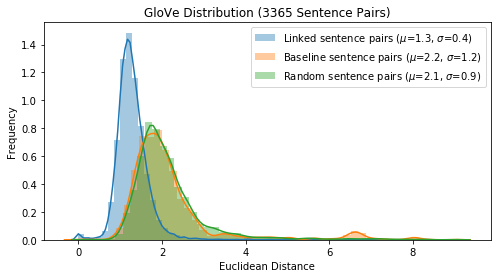

In [453]:
fig = plt.figure(figsize = (8, 4))
mu = valid_df.dist_linked_glove_euc.mean()
sigma = valid_df.dist_linked_glove_euc.std()
sns.distplot(valid_df.dist_linked_glove_euc, label = "Linked sentence pairs ($\mu$={:.1f}, $\sigma$={:.1f})".format(mu, sigma))
mu = valid_df.dist_baseline_glove_euc.mean()
sigma = valid_df.dist_baseline_glove_euc.std()
sns.distplot(valid_df.dist_baseline_glove_euc, label = "Baseline sentence pairs ($\mu$={:.1f}, $\sigma$={:.1f})".format(mu, sigma))
mu = valid_df.dist_random_glove_euc.mean()
sigma = valid_df.dist_random_glove_euc.std()
sns.distplot(valid_df.dist_random_glove_euc, label = "Random sentence pairs ($\mu$={:.1f}, $\sigma$={:.1f})".format(mu, sigma))
plt.legend()
plt.title("GloVe Distribution ({} Sentence Pairs)".format(valid_df.shape[0]))
plt.xlabel("Euclidean Distance")
plt.ylabel("Frequency")
fig.savefig(eda_path + '/glove_euc.png')

/usr/local/anaconda3/envs/insight/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


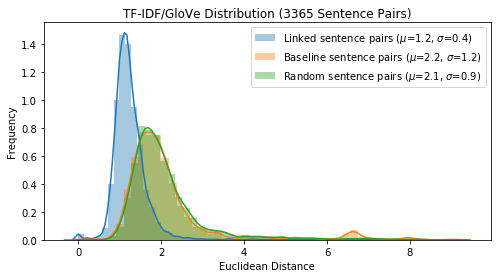

In [454]:
fig = plt.figure(figsize = (8, 4))
mu = valid_df.dist_linked_tfidf_glove_euc.mean()
sigma = valid_df.dist_linked_tfidf_glove_euc.std()
sns.distplot(valid_df.dist_linked_tfidf_glove_euc, label = "Linked sentence pairs ($\mu$={:.1f}, $\sigma$={:.1f})".format(mu, sigma))
mu = valid_df.dist_baseline_tfidf_glove_euc.mean()
sigma = valid_df.dist_baseline_tfidf_glove_euc.std()
sns.distplot(valid_df.dist_baseline_tfidf_glove_euc, label = "Baseline sentence pairs ($\mu$={:.1f}, $\sigma$={:.1f})".format(mu, sigma))
mu = valid_df.dist_random_tfidf_glove_euc.mean()
sigma = valid_df.dist_random_tfidf_glove_euc.std()
sns.distplot(valid_df.dist_random_tfidf_glove_euc, label = "Random sentence pairs ($\mu$={:.1f}, $\sigma$={:.1f})".format(mu, sigma))
plt.legend()
plt.title("TF-IDF/GloVe Distribution ({} Sentence Pairs)".format(valid_df.shape[0]))
plt.xlabel("Euclidean Distance")
plt.ylabel("Frequency")
fig.savefig(eda_path + '/tfidf_glove_euc.png')

In [5]:
bilink_ind = 0

while True:
    origin_title, target_title = bilinks_df[['origin_title', 'target_title']].iloc[bilink_ind].tolist()

    origin_wapi_params = {
        'action': "parse",
        'maxlag': 5,
        'page': origin_title,
        'prop': "text",
        'contentformat': "text/plain",
        'format': "json"
    }

    try:
        origin_data = sess.get(url = wapi_url, params = origin_wapi_params).json()
        origin_title_norm = origin_data['parse']['title']
        origin_text = origin_data['parse']['text']['*']
    except KeyError:
        continue

    origin_soup = BeautifulSoup(origin_text, 'html5lib')

    target_wapi_params = {
        'action': "parse",
        'maxlag': 5,
        'page': target_title,
        'prop': "text",
        'format': "json"
    }

    try:
        target_data = sess.get(url = wapi_url, params = target_wapi_params).json()
        target_title_norm = target_data['parse']['title']
        target_text = target_data['parse']['text']['*']
    except KeyError:
        continue
    
    target_soup = BeautifulSoup(target_text, 'html5lib')
    
    break

In [102]:
origin_sents = []
origin_relevant_inds = []
sent_ind = 0
for p in origin_soup.find_all('p'):
    for p_split in p.decode_contents().split('\n'):
        for sent in nltk.sent_tokenize(p_split):
            sent_content = BeautifulSoup(sent, 'html5lib').body.get_text().replace(u'\xa0', u' ')
            sent_content = re.sub('\[.*?\]', '', sent_content)
            sent_content = ' '.join(tok.load(sent_content).word_tokenize(lemmatize = True).word_tokens)
            if len(sent_content) > 0:
                if target_title_norm in sent:
                    origin_relevant_inds.append(sent_ind)
                origin_sents.append(sent_content)
                sent_ind += 1
origin_sents = np.array(origin_sents)

target_sents = []
target_relevant_inds = []
sent_ind = 0
for p in target_soup.find_all('p'):
    for p_split in p.decode_contents().split('\n'):
        for sent in nltk.sent_tokenize(p_split):
            sent_content = BeautifulSoup(sent, 'html5lib').body.get_text().replace(u'\xa0', u' ')
            sent_content = re.sub('\[.*?\]', '', sent_content)
            sent_content = ' '.join(tok.load(sent_content).word_tokenize(lemmatize = True).word_tokens)
            if len(sent_content) > 0:
                if origin_title_norm in sent:
                    target_relevant_inds.append(sent_ind)
                target_sents.append(sent_content)
                sent_ind += 1
target_sents = np.array(target_sents)

In [288]:
if (origin_sents.size > 0) and (len(origin_relevant_inds) > 0) and (target_sents.size > 0) and (len(target_relevant_inds) > 0):
    wiki2vec_df = populate_dataframe(wiki2vec_vectorizer, origin_title, target_title,
                                     origin_sents, target_sents,
                                     origin_relevant_inds, target_relevant_inds,
                                     n_selected = 10, scale = 10)

    tfidf_wiki2vec_df = populate_dataframe(tfidf_wiki2vec_vectorizer, origin_title, target_title,
                                           origin_sents, target_sents,
                                           origin_relevant_inds, target_relevant_inds,
                                           n_selected = 10, scale = 10)
    tfidf_wiki2vec_df = tfidf_wiki2vec_df.rename(columns = dict([(x, 'tfidf_' + x) for x in tfidf_wiki2vec_df.columns if '_title' not in x]))

    valid_df = pd.concat([wiki2vec_df, tfidf_wiki2vec_df.drop(columns = ['origin_title', 'target_title'])], axis = 1)

In [6]:
valid_df = pd.read_csv(data_path + '/clickstream-enwiki-2018-08-validation.tsv', sep = '\t')

/usr/local/anaconda3/envs/insight/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


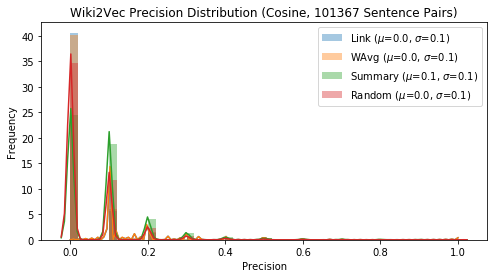

In [19]:
fig = plt.figure(figsize = (8, 4))
mu, sigma = valid_df.cos_link_precision.mean(), valid_df.cos_link_precision.std()
sns.distplot(valid_df.cos_link_precision, label = "Link ($\mu$={:.1f}, $\sigma$={:.1f})".format(mu, sigma))
mu, sigma = valid_df.cos_wavg_precision.mean(), valid_df.cos_wavg_precision.std()
sns.distplot(valid_df.cos_wavg_precision, label = "WAvg ($\mu$={:.1f}, $\sigma$={:.1f})".format(mu, sigma))
mu, sigma = valid_df.cos_summ_precision.mean(), valid_df.cos_summ_precision.std()
sns.distplot(valid_df.cos_summ_precision, label = "Summary ($\mu$={:.1f}, $\sigma$={:.1f})".format(mu, sigma))
mu, sigma = valid_df.cos_rand_precision.mean(), valid_df.cos_rand_precision.std()
sns.distplot(valid_df.cos_rand_precision, label = "Random ($\mu$={:.1f}, $\sigma$={:.1f})".format(mu, sigma))
plt.legend()
plt.title("Wiki2Vec Precision Distribution (Cosine, {} Sentence Pairs)".format(valid_df.shape[0]))
plt.xlabel("Precision")
plt.ylabel("Frequency")
fig.savefig(eda_path + '/cos_wiki2vec_precision.png')

/usr/local/anaconda3/envs/insight/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


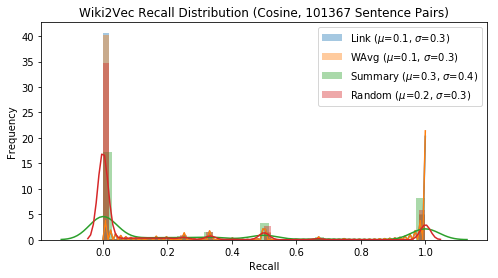

In [18]:
fig = plt.figure(figsize = (8, 4))
mu, sigma = valid_df.cos_link_recall.mean(), valid_df.cos_link_recall.std()
sns.distplot(valid_df.cos_link_recall, label = "Link ($\mu$={:.1f}, $\sigma$={:.1f})".format(mu, sigma))
mu, sigma = valid_df.cos_wavg_recall.mean(), valid_df.cos_wavg_recall.std()
sns.distplot(valid_df.cos_wavg_recall, label = "WAvg ($\mu$={:.1f}, $\sigma$={:.1f})".format(mu, sigma))
mu, sigma = valid_df.cos_summ_recall.mean(), valid_df.cos_summ_recall.std()
sns.distplot(valid_df.cos_summ_recall, label = "Summary ($\mu$={:.1f}, $\sigma$={:.1f})".format(mu, sigma))
mu, sigma = valid_df.cos_rand_recall.mean(), valid_df.cos_rand_recall.std()
sns.distplot(valid_df.cos_rand_recall, label = "Random ($\mu$={:.1f}, $\sigma$={:.1f})".format(mu, sigma))
plt.legend()
plt.title("Wiki2Vec Recall Distribution (Cosine, {} Sentence Pairs)".format(valid_df.shape[0]))
plt.xlabel("Recall")
plt.ylabel("Frequency")
fig.savefig(eda_path + '/cos_wiki2vec_recall.png')

/usr/local/anaconda3/envs/insight/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


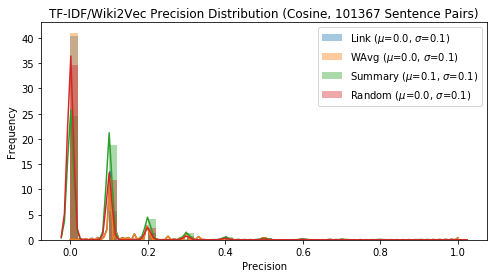

In [10]:
fig = plt.figure(figsize = (8, 4))
mu, sigma = valid_df.cos_tfidf_link_precision.mean(), valid_df.cos_tfidf_link_precision.std()
sns.distplot(valid_df.cos_tfidf_link_precision, label = "Link ($\mu$={:.1f}, $\sigma$={:.1f})".format(mu, sigma))
mu, sigma = valid_df.cos_tfidf_wavg_precision.mean(), valid_df.cos_tfidf_wavg_precision.std()
sns.distplot(valid_df.cos_tfidf_wavg_precision, label = "WAvg ($\mu$={:.1f}, $\sigma$={:.1f})".format(mu, sigma))
mu, sigma = valid_df.cos_tfidf_summ_precision.mean(), valid_df.cos_tfidf_summ_precision.std()
sns.distplot(valid_df.cos_tfidf_summ_precision, label = "Summary ($\mu$={:.1f}, $\sigma$={:.1f})".format(mu, sigma))
mu, sigma = valid_df.cos_tfidf_rand_precision.mean(), valid_df.cos_tfidf_rand_precision.std()
sns.distplot(valid_df.cos_tfidf_rand_precision, label = "Random ($\mu$={:.1f}, $\sigma$={:.1f})".format(mu, sigma))
plt.legend()
plt.title("TF-IDF/Wiki2Vec Precision Distribution (Cosine, {} Sentence Pairs)".format(valid_df.shape[0]))
plt.xlabel("Precision")
plt.ylabel("Frequency")
fig.savefig(eda_path + '/cos_tfidf_wiki2vec_precision.png')

/usr/local/anaconda3/envs/insight/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


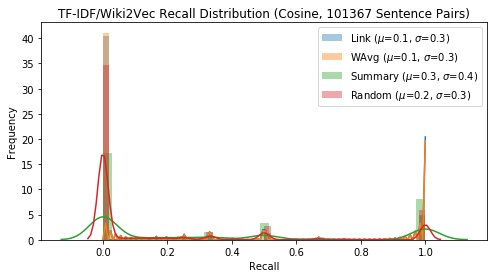

In [11]:
fig = plt.figure(figsize = (8, 4))
mu, sigma = valid_df.cos_tfidf_link_recall.mean(), valid_df.cos_tfidf_link_recall.std()
sns.distplot(valid_df.cos_tfidf_link_recall, label = "Link ($\mu$={:.1f}, $\sigma$={:.1f})".format(mu, sigma))
mu, sigma = valid_df.cos_tfidf_wavg_recall.mean(), valid_df.cos_tfidf_wavg_recall.std()
sns.distplot(valid_df.cos_tfidf_wavg_recall, label = "WAvg ($\mu$={:.1f}, $\sigma$={:.1f})".format(mu, sigma))
mu, sigma = valid_df.cos_tfidf_summ_recall.mean(), valid_df.cos_tfidf_summ_recall.std()
sns.distplot(valid_df.cos_tfidf_summ_recall, label = "Summary ($\mu$={:.1f}, $\sigma$={:.1f})".format(mu, sigma))
mu, sigma = valid_df.cos_tfidf_rand_recall.mean(), valid_df.cos_tfidf_rand_recall.std()
sns.distplot(valid_df.cos_tfidf_rand_recall, label = "Random ($\mu$={:.1f}, $\sigma$={:.1f})".format(mu, sigma))
plt.legend()
plt.title("TF-IDF/Wiki2Vec Recall Distribution (Cosine, {} Sentence Pairs)".format(valid_df.shape[0]))
plt.xlabel("Recall")
plt.ylabel("Frequency")
fig.savefig(eda_path + '/cos_tfidf_wiki2vec_recall.png')

/usr/local/anaconda3/envs/insight/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


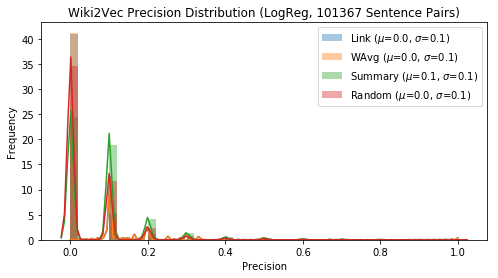

In [12]:
fig = plt.figure(figsize = (8, 4))
mu, sigma = valid_df.logreg_link_precision.mean(), valid_df.logreg_link_precision.std()
sns.distplot(valid_df.logreg_link_precision, label = "Link ($\mu$={:.1f}, $\sigma$={:.1f})".format(mu, sigma))
mu, sigma = valid_df.logreg_wavg_precision.mean(), valid_df.logreg_wavg_precision.std()
sns.distplot(valid_df.logreg_wavg_precision, label = "WAvg ($\mu$={:.1f}, $\sigma$={:.1f})".format(mu, sigma))
mu, sigma = valid_df.logreg_summ_precision.mean(), valid_df.logreg_summ_precision.std()
sns.distplot(valid_df.logreg_summ_precision, label = "Summary ($\mu$={:.1f}, $\sigma$={:.1f})".format(mu, sigma))
mu, sigma = valid_df.logreg_rand_precision.mean(), valid_df.logreg_rand_precision.std()
sns.distplot(valid_df.logreg_rand_precision, label = "Random ($\mu$={:.1f}, $\sigma$={:.1f})".format(mu, sigma))
plt.legend()
plt.title("Wiki2Vec Precision Distribution (LogReg, {} Sentence Pairs)".format(valid_df.shape[0]))
plt.xlabel("Precision")
plt.ylabel("Frequency")
fig.savefig(eda_path + '/logreg_wiki2vec_precision.png')

/usr/local/anaconda3/envs/insight/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


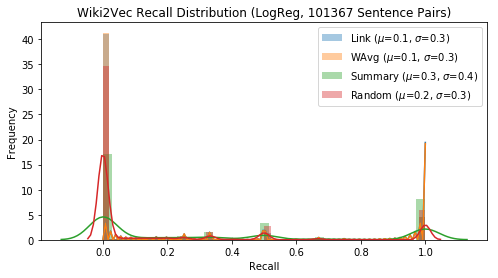

In [13]:
fig = plt.figure(figsize = (8, 4))
mu, sigma = valid_df.logreg_link_recall.mean(), valid_df.logreg_link_recall.std()
sns.distplot(valid_df.logreg_link_recall, label = "Link ($\mu$={:.1f}, $\sigma$={:.1f})".format(mu, sigma))
mu, sigma = valid_df.logreg_wavg_recall.mean(), valid_df.logreg_wavg_recall.std()
sns.distplot(valid_df.logreg_wavg_recall, label = "WAvg ($\mu$={:.1f}, $\sigma$={:.1f})".format(mu, sigma))
mu, sigma = valid_df.logreg_summ_recall.mean(), valid_df.logreg_summ_recall.std()
sns.distplot(valid_df.logreg_summ_recall, label = "Summary ($\mu$={:.1f}, $\sigma$={:.1f})".format(mu, sigma))
mu, sigma = valid_df.logreg_rand_recall.mean(), valid_df.logreg_rand_recall.std()
sns.distplot(valid_df.logreg_rand_recall, label = "Random ($\mu$={:.1f}, $\sigma$={:.1f})".format(mu, sigma))
plt.legend()
plt.title("Wiki2Vec Recall Distribution (LogReg, {} Sentence Pairs)".format(valid_df.shape[0]))
plt.xlabel("Recall")
plt.ylabel("Frequency")
fig.savefig(eda_path + '/logreg_wiki2vec_recall.png')

/usr/local/anaconda3/envs/insight/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


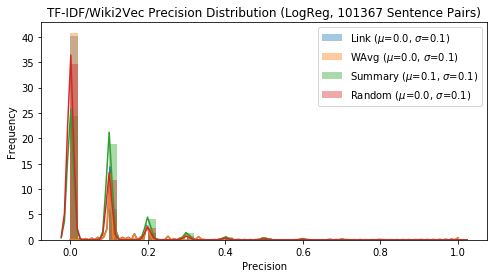

In [14]:
fig = plt.figure(figsize = (8, 4))
mu, sigma = valid_df.logreg_tfidf_link_precision.mean(), valid_df.logreg_tfidf_link_precision.std()
sns.distplot(valid_df.logreg_tfidf_link_precision, label = "Link ($\mu$={:.1f}, $\sigma$={:.1f})".format(mu, sigma))
mu, sigma = valid_df.logreg_tfidf_wavg_precision.mean(), valid_df.logreg_tfidf_wavg_precision.std()
sns.distplot(valid_df.logreg_tfidf_wavg_precision, label = "WAvg ($\mu$={:.1f}, $\sigma$={:.1f})".format(mu, sigma))
mu, sigma = valid_df.logreg_tfidf_summ_precision.mean(), valid_df.logreg_tfidf_summ_precision.std()
sns.distplot(valid_df.logreg_tfidf_summ_precision, label = "Summary ($\mu$={:.1f}, $\sigma$={:.1f})".format(mu, sigma))
mu, sigma = valid_df.logreg_tfidf_rand_precision.mean(), valid_df.logreg_tfidf_rand_precision.std()
sns.distplot(valid_df.logreg_tfidf_rand_precision, label = "Random ($\mu$={:.1f}, $\sigma$={:.1f})".format(mu, sigma))
plt.legend()
plt.title("TF-IDF/Wiki2Vec Precision Distribution (LogReg, {} Sentence Pairs)".format(valid_df.shape[0]))
plt.xlabel("Precision")
plt.ylabel("Frequency")
fig.savefig(eda_path + '/logreg_tfidf_wiki2vec_precision.png')

/usr/local/anaconda3/envs/insight/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


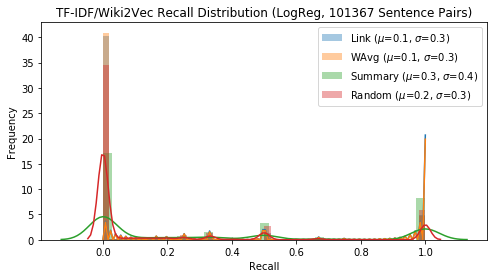

In [15]:
fig = plt.figure(figsize = (8, 4))
mu, sigma = valid_df.logreg_tfidf_link_recall.mean(), valid_df.logreg_tfidf_link_recall.std()
sns.distplot(valid_df.logreg_tfidf_link_recall, label = "Link ($\mu$={:.1f}, $\sigma$={:.1f})".format(mu, sigma))
mu, sigma = valid_df.logreg_tfidf_wavg_recall.mean(), valid_df.logreg_tfidf_wavg_recall.std()
sns.distplot(valid_df.logreg_tfidf_wavg_recall, label = "WAvg ($\mu$={:.1f}, $\sigma$={:.1f})".format(mu, sigma))
mu, sigma = valid_df.logreg_tfidf_summ_recall.mean(), valid_df.logreg_tfidf_summ_recall.std()
sns.distplot(valid_df.logreg_tfidf_summ_recall, label = "Summary ($\mu$={:.1f}, $\sigma$={:.1f})".format(mu, sigma))
mu, sigma = valid_df.logreg_tfidf_rand_recall.mean(), valid_df.logreg_tfidf_rand_recall.std()
sns.distplot(valid_df.logreg_tfidf_rand_recall, label = "Random ($\mu$={:.1f}, $\sigma$={:.1f})".format(mu, sigma))
plt.legend()
plt.title("TF-IDF/Wiki2Vec Recall Distribution (LogReg, {} Sentence Pairs)".format(valid_df.shape[0]))
plt.xlabel("Recall")
plt.ylabel("Frequency")
fig.savefig(eda_path + '/logreg_tfidf_wiki2vec_recall.png')